## Set-up environment

We install 🤗 Transformers, which includes many awesome models, including TrOCR by Microsoft Research.

In [1]:
uv add transformers

/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/.venv/bin/python: No module named uv
Note: you may need to restart the kernel to use updated packages.


## Load image

Here we load an image from the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), on which TrOCR was fine-tuned.

/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fki.tic.heia-fr.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


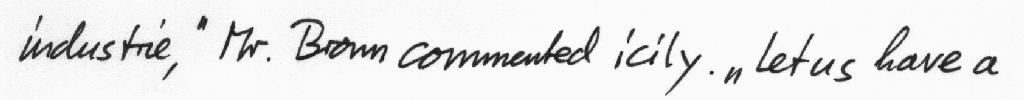

In [1]:
import requests
from PIL import Image

url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg"

response = requests.get(url, stream=True, verify=False)
image = Image.open(response.raw).convert("RGB")

image

## Prepare image for model

Next, we use `TrOCRProcessor` (which wraps a `ViTFeatureExtractor` and a `RobertaTokenizer` into one) to resize + normalize the image for the model.

In [2]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# calling the processor is equivalent to calling the feature extractor
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


torch.Size([1, 3, 384, 384])


## Load model

Here we load a TrOCR model from the [hub](https://huggingface.co/models?other=trocr). TrOCR models are instances of [`VisionEncoderDecoderModel`](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder), which combine a vision encoder (like ViT, BEiT, DeiT, ...) with a language model as decoder (like BERT, RoBERTa, GPT-2, ...).

In [3]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Generate text

Finally, we can generate text autoregressively using the `.generate()` method. We use the tokenizer part of the `processor` to decode the generated id's back to text. Note that by default, greedy search is used for generation, but there are more fancy methods like beam search and top-k sampling, which are also supported. You can check out [this blog post](https://huggingface.co/blog/how-to-generate) for details.

In [4]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

industry , " Mr. Brown commented icily . " Let us have a


## Gradio demo

We can also wrap up everything we wrote above in a quick [Gradio](https://gradio.app/) demo. Gradio is an awesome tool for creating quick ML demos!

We just need to define a function that takes in an image input and produces a text output (note that Gradio supports many other input & output formats)!

In [ ]:
import gradio as gr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# load image examples from the IAM database
urls = ['https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSoolxi9yWGAT5SLZShv8vVd0bz47UWRzQC19fDTeE8GmGv_Rn-PCF1pP1rrUx8kOjA4gg&usqp=CAU',
        'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRNYtTuSBpZPV_nkBYPMFwVVD9asZOPgHww4epu9EqWgDmXW--sE2o8og40ZfDGo87j5w&usqp=CAU']
for idx, url in enumerate(urls):
  image = Image.open(requests.get(url, stream=True, verify=False).raw)
  image.save(f"image_{idx}.png")

def process_image(image):
    # prepare image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # generate (no beam search)
    generated_ids = model.generate(pixel_values)

    # decode
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

title = "Interactive demo: TrOCR"
description = "Demo for Microsoft's TrOCR, an encoder-decoder model consisting of an image Transformer encoder and a text Transformer decoder for state-of-the-art optical character recognition (OCR) on single-text line images. This particular model is fine-tuned on IAM, a dataset of annotated handwritten images. To use it, simply upload an image or use the example image below and click 'submit'. Results will show up in a few seconds."
article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2109.10282'>TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models</a> | <a href='https://github.com/microsoft/unilm/tree/master/trocr'>Github Repo</a></p>"
examples =[["image_0.png"], ["image_1.png"], ["image_2.png"]]

iface = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title=title,
    description=description,
    article=article,
    examples=examples
)
iface.launch(debug=True)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fki.tic.heia-fr.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'encrypted-tbn0.gstatic.com'. Adding certificate verification is strongly advised. See: https://url

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
Traceback (most recent call last):
  File "/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/.venv/lib/python3.13/site-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/.venv/lib/python3.13/site-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "/Users/tomamirault/Documents/projects/p1-dty-rte/detection-no